<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/7_Linear_multiclass_classification/7_5_Categorical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 7: Linear multi-class classification

#  7.5  The Categorical Cross Entropy Cost Function

In the previous Sections we have employed by default the numerical label values $y_p \in \left\{0,1,...,C-1\right\}$.  However like the two class case - as discussed in [Section 6.6](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_6_Categorical.html) - the choice of label values with multi-class classification *is arbitrary*.  We can use other numerical values if we desire - or even unordered objects like one-hot encoded vectors.  However regardless of how we define our labels we still end up building the same sort multi-class classifier we have seen previously - tuning its weights by minimization of a familiar cost function like e.g., the Multi-class Softmax / Cross Entropy cost.

In this Section we show how to use *categorical* labels, that is labels that have no intrinsic numerical order, to perform multi-class classification.  This perspective introduces the notion of a *discrete probabilistic predictions*, as well as the notion of a *Categorical Cross Entropy* cost function (which - as we will see - is precisely the Softmax cost function we saw in the previous Section).

In [ ]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone datasets
    if not Path('chapter_7_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/7_Linear_multiclass_classification/chapter_7_library
    else:
        print('chapter_7_library already cloned!')

    # clone library subdirectory
    if not Path('chapter_7_datasets').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/7_Linear_multiclass_classification/chapter_7_datasets
    else:
        print('chapter_7_datasets already cloned!')

    # clone datasets
    if not Path('chapter_7_images').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/7_Linear_multiclass_classification/chapter_7_images
    else:
        print('chapter_7_images already cloned!')

# image paths
image_path_1 = "chapter_7_images/discrete_prob_dist.png"
image_path_2 = "chapter_7_images/exponentially_normalized_histogram.png"
image_path_3 = "chapter_7_images/multiclass_histogram.png"

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

##  Discrete probability distributions

Suppose you took a poll of $10$ friends or work colleagues inquiring if they owned a pet cat or dog.  From this group you learned that $3$ people owned neither a cat or a dog, $1$ person owned a cat, and $6$ people owned dogs.   The corresponding data vector $\mathbf{s} = \begin{bmatrix} 3,\, 1,\, 6\end{bmatrix}$ is often reprsented *visually* as a *histogam*, where the value of each entry is represented by a *bar* whose height is made proportional to its respective value.  A histogram of the toy data vector described here is shown in left panel of the Figure below.

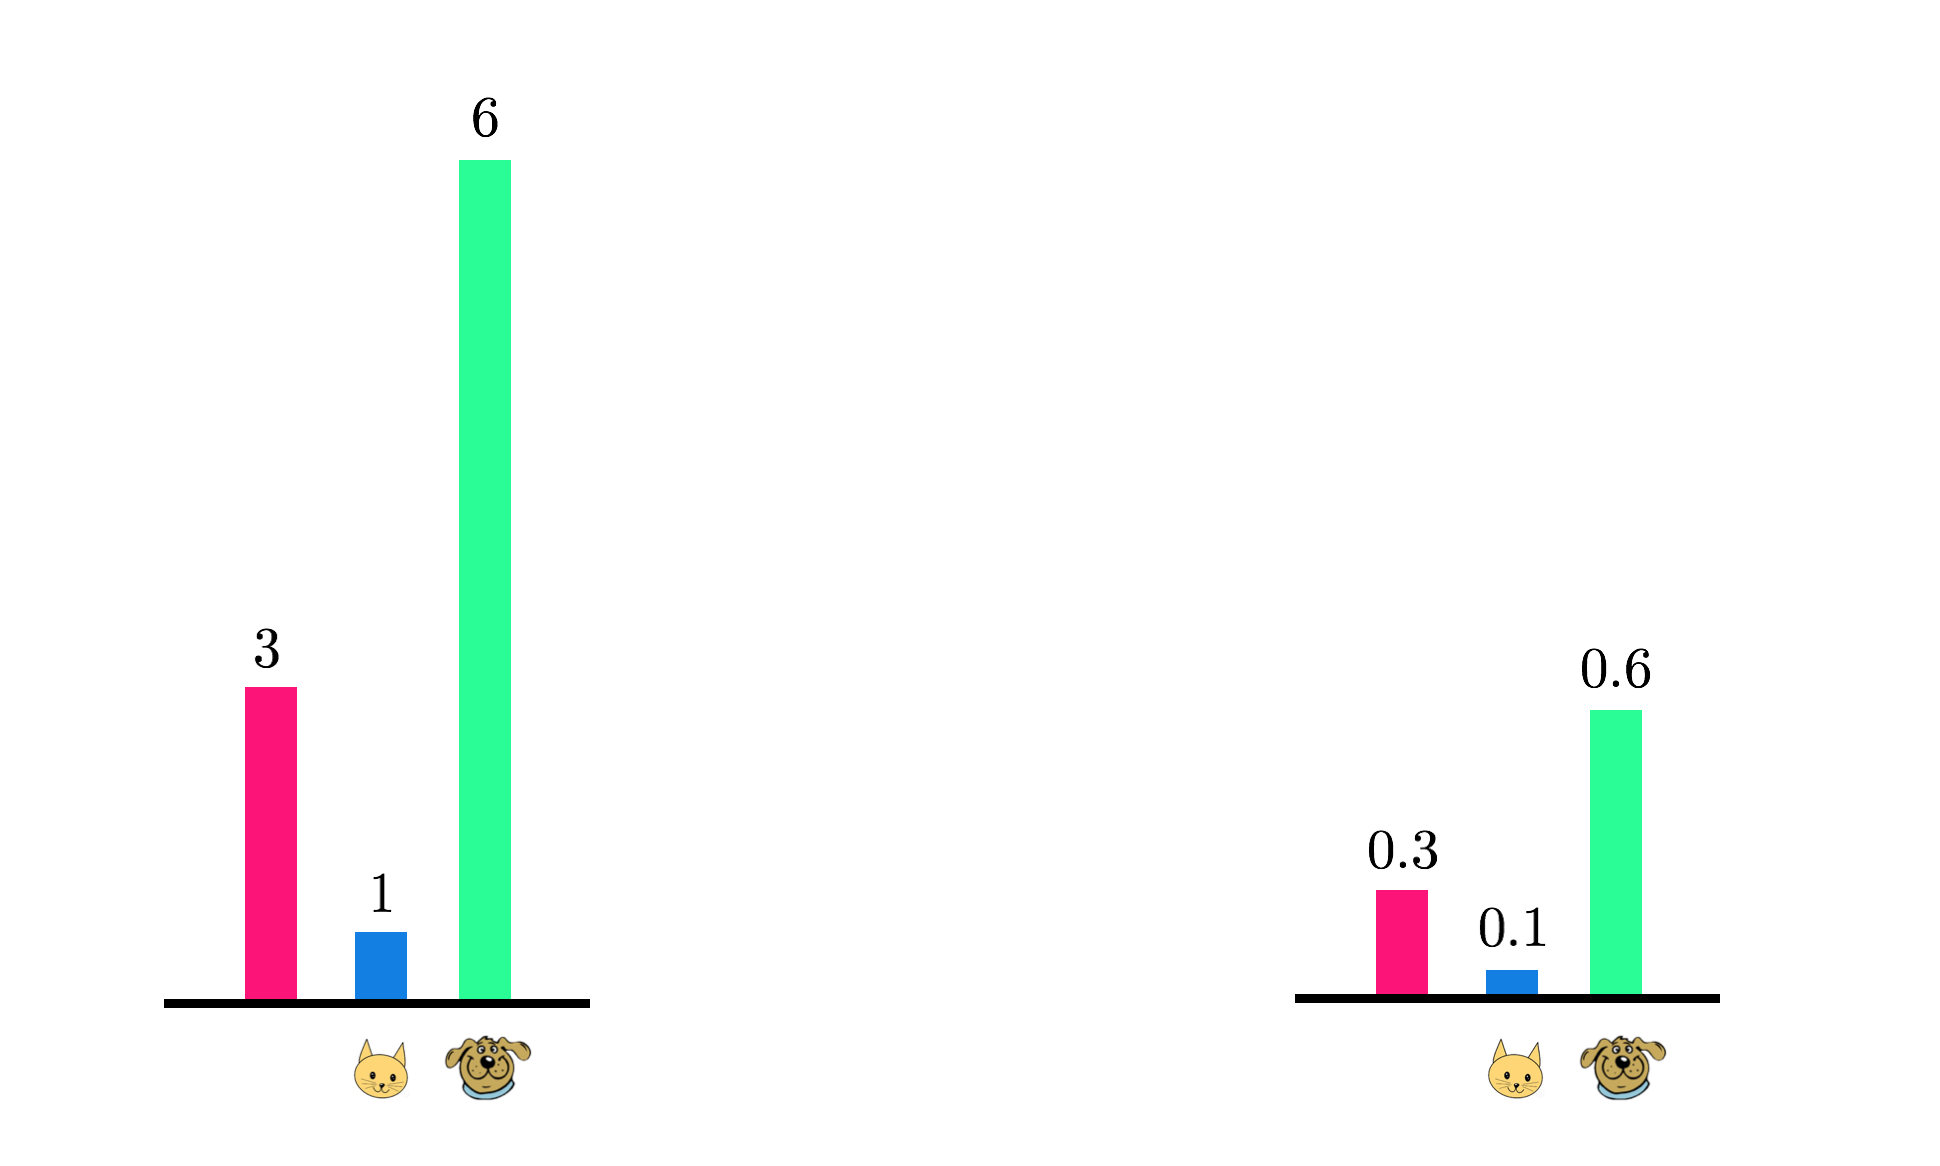

In [ ]:
Image(image_path_1)

<figure>
  <figcaption>   
<strong>Figure 1:</strong>
    <em> (left panel) A length $C = 3$ vector $\mathbf{s}$ shown as a *histogram*.  The entries of this vector - from left to right - represent the number of individuals (out of $10$ in total) who own neither a cat or dog, own a cat, or own a dog.  (right panel)  Normalizing this vector by dividing off its sum from each allows us to treat it as a discrete probability distribution.
</em>  
</figcaption> 
</figure>

It is quite common to *normalize* data vectors like this so that that they can be interpreted as *discrete probability distributions*.  This simply involves normalizing the vector so that i) the numerical ordering of its values (from smallest to largest) is retained, its values are nonnefative, and its values sum exactly to $1$.  For a vector of all nonnegative entries this can be done by simply dividing it by the sum of its values.  For example, with the toy example we use here since its values sum to $3 + 1 + 6 = 10$ this requires simply dividing all entries by $10$ as

\begin{equation}
\mathbf{s}  = \begin{bmatrix} \frac{3}{10},\, \frac{1}{10},\, \frac{6}{10}\end{bmatrix} =  \begin{bmatrix} 0.3,\, 0.1,\, 0.6\end{bmatrix}.
\end{equation}

In doing this we have retained the numerical ordering of the entries, each entry's nonnegativity, and its sum is now precisely equal to one.  We can now say that that $0.3 = 30\%$ of those individuals sampled owned neither a cat or a dog, $0.1 = 10\%$ owned a cat, and $0.6 = 60\%$ owned a dog.  In probabalistic terms we can make statements like   e.g., "with $60\%$ probability an individual from our sample owned a dog".

##  Exponential normalization

Notice what happens if we take any arbitrary $C$ length vector $\mathbf{s}_{\,} = \begin{bmatrix}  s_0,\, s_1,\,...,s_{C-1} \end{bmatrix}$ - where the scalar values $s_c$ can take on any values - and *exponentiate* each of its element of it as

\begin{equation}
\begin{bmatrix}  e^{s_0},\, e^{s_1},\,...,e^{s_{C-1}} \end{bmatrix}.
\end{equation}

Because the exponential function $e^{\left(\cdot\right)}$ is *always nonnegative*, each of the exponentiated values is nonnegative as well.  Also notice how exponentiating *maintains the ordering of values in $\mathbf{s}$ from small to large*.  So, for example, if $\mathbf{s} = \begin{bmatrix} 1 , \, 3, \, -4 \end{bmatrix}$ and we exponentiate as $\begin{bmatrix} e^1 ,\, e^3 , \, e^{-4} \end{bmatrix}$, all values become nonnegative *and* the ordering of the values from smallest to largest does not change.

If we divide off the sum of this exponentiated version $\mathbf{s}$ from each of its entries as

\begin{equation}
\sigma \left(\mathbf{s}\right) = \begin{bmatrix}  \frac{e^{s_0}}{\sum_{c=0}^{C-1} e^{s_c}},\, \frac{e^{s_1}}{\sum_{c=0}^{C-1} e^{s_c}},\,...,\frac{e^{s_{C-1}}}{\sum_{c=0}^{C-1} e^{s_c}} \end{bmatrix}
\end{equation}

we maintain these properties but - in addition - normalize it so *sum that the sum of $\sigma\left(\mathbf{s}\right)$ equals one exactly.  If we denote by $\sigma_c$ the $c^{th}$ element of the vector $\sigma\left(\mathbf{s}\right)$ we have

\begin{equation}
\sum_{j = 0}^C \sigma_j = \sum_{j=0}^{C-1} \left(\frac{e^{s_{j}}}{\sum_{c=0}^{C-1} e^{s_c}}\right) =  \frac{\sum_{j=0}^{C-1} e^{s_{j}}}{\sum_{c=0}^{C-1} e^{s_c}}= 1.
\end{equation}

Moreover each entry of $\sigma\left(\mathbf{s}\right)$ is now *bounded between zero and one* since regardless of the values of $\mathbf{s}$ we always have that 

\begin{equation}
0 \leq \frac{e^{s_j}}{\sum_{c=0}^{C-1} e^{s_c}} \leq 1.
\end{equation}

This function $\sigma\left(\cdot\right)$ is called a *normalized exponential function*, and can be thought of as a generalization of the *sigmoid* introduced in [Section 6.2](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_2_Cross_entropy.html).  It is often used so that we may think of about an arbitrary vector $\mathbf{s}$ (possibly containing negative as well as positive entries) as a *discrete probability distribution*.  Using this transformation the *largest* entry of $\mathbf{s}$ is turned into the value $\sigma\left(\mathbf{s}\right)$ *closest* to $1$, and smallest value the one closest to $0$. 

These properties of the normalized exponential are illustrated for a particular length $C = 3$ vector $\mathbf{s}$ in the figure below, where show both $\mathbf{s}$ and its exponentially normailzed version are shown as *histograms*.  Here the height of each bar equals the value of each entry of the vector (this height can be *negative* if the value itself is negative), and the values are listed off from left to right.  

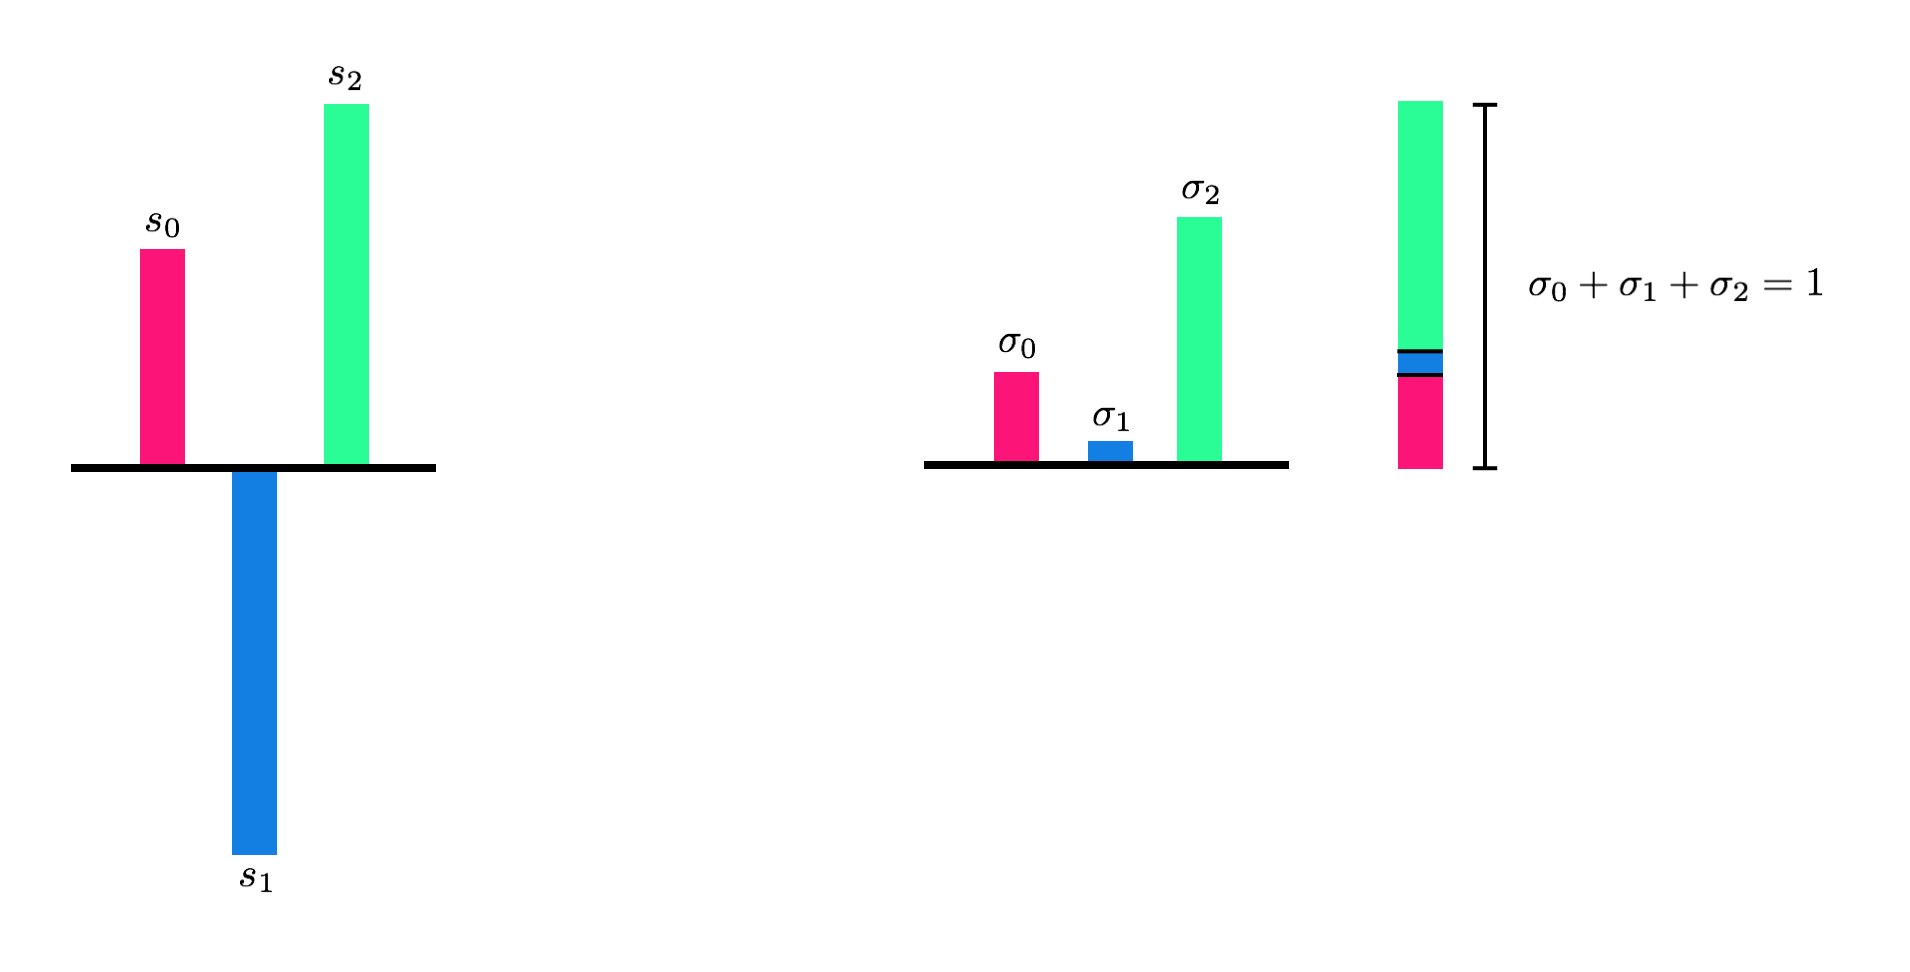

In [ ]:
Image(image_path_2)

<figure>
  <figcaption>   
<strong>Figure 2:</strong> <em> A length $C = 3$ vector $\mathbf{s}$ shown as a *histogram*.  In this particular example the first and third entry of $\mathbf{s}$ are positive with the middle entry being negative.  (right panel)  Taking teh normalized exponential of this produces a new vector of all nonnegative entries whose numerical order is preserved, and whose total value sums to $1$.
</em>  </figcaption> 
</figure>

Note that the normalized exponential also called - often in the context of neural networks - the *softmax activation*.  This naming convention is unfortunate, as the normalized exponential is *not* a soft version of the $\text{max}$ function as the rightly named *softmax function* detailed in e.g., [Section 7.3](https://jermwatt.github.io/machine_learning_refined/notes/7_Linear_multiclass_classification/7_3_Perceptron.html) is and should not be confused with it.  While it is a transformation that does *preserve* the index of the largest entry of its input, it is not a soft version of the $\text{argmax}$ function either (as it is sometimes erroneously claimed to be). 

##  Exponentially normalized signed distances

In previous Sections have rightfully relied on a point $\mathbf{x}$'s *signed distance* to each of the $C$ individual decision boundaries (or something very close to it if we do not normalize feature-touching weights) to properly determine class membership.  This is codified directly in the fusion rule itself.

For a given setting of our weights, the evaluation of $\mathbf{x}$ through all $C$ decision boundaries produces $C$ signed distance measurments

\begin{equation}
\begin{matrix} 
\mathring{\mathbf{x}}_{\,}^T\mathbf{W} \end{matrix}  = \begin{bmatrix}
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{0}^{\,}   &
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{1}^{\,}   &
\cdots \, &
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{C-1}^{\,}
\end{bmatrix}
\end{equation}

which we can think of as a *histogram*. 

Because - as we have seen above - the *normalized exponential function* preserves numerical order we can likewise consider the *exponentially normalized signed distance* in determining proper class ownership.  Denoting the $\sigma\left(\cdot\right)$ the normalized exponential our generic histogram of signed distnaces becomes


\begin{equation}
\begin{matrix} 
\sigma \left(\mathring{\mathbf{x}}_{\,}^T\mathbf{W} \right) \end{matrix} = \begin{bmatrix}
\frac{  e^{\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{0}^{\,} } }  {\sum_{c = 0}^{C-1} e^{\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{c}^{\,} } } &
\frac{  e^{\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{1}^{\,} } }  {\sum_{c = 0}^{C-1} e^{\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{c}^{\,} } } &
\cdots \, &
\frac{  e^{\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{C-1}^{\,} } }  {\sum_{c = 0}^{C-1} e^{\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{c}^{\,} } }
\end{bmatrix}.
\end{equation}

In the figure below we use the prototype $C = 3$ class dataset (introduced in [Section 7.2](https://jermwatt.github.io/machine_learning_refined/notes/7_Linear_multiclass_classification/7_2_OvA.html)) and visualize both signed distance vectors as histograms for several points (left panel) as well as their normalized exponential versions (right panel). 

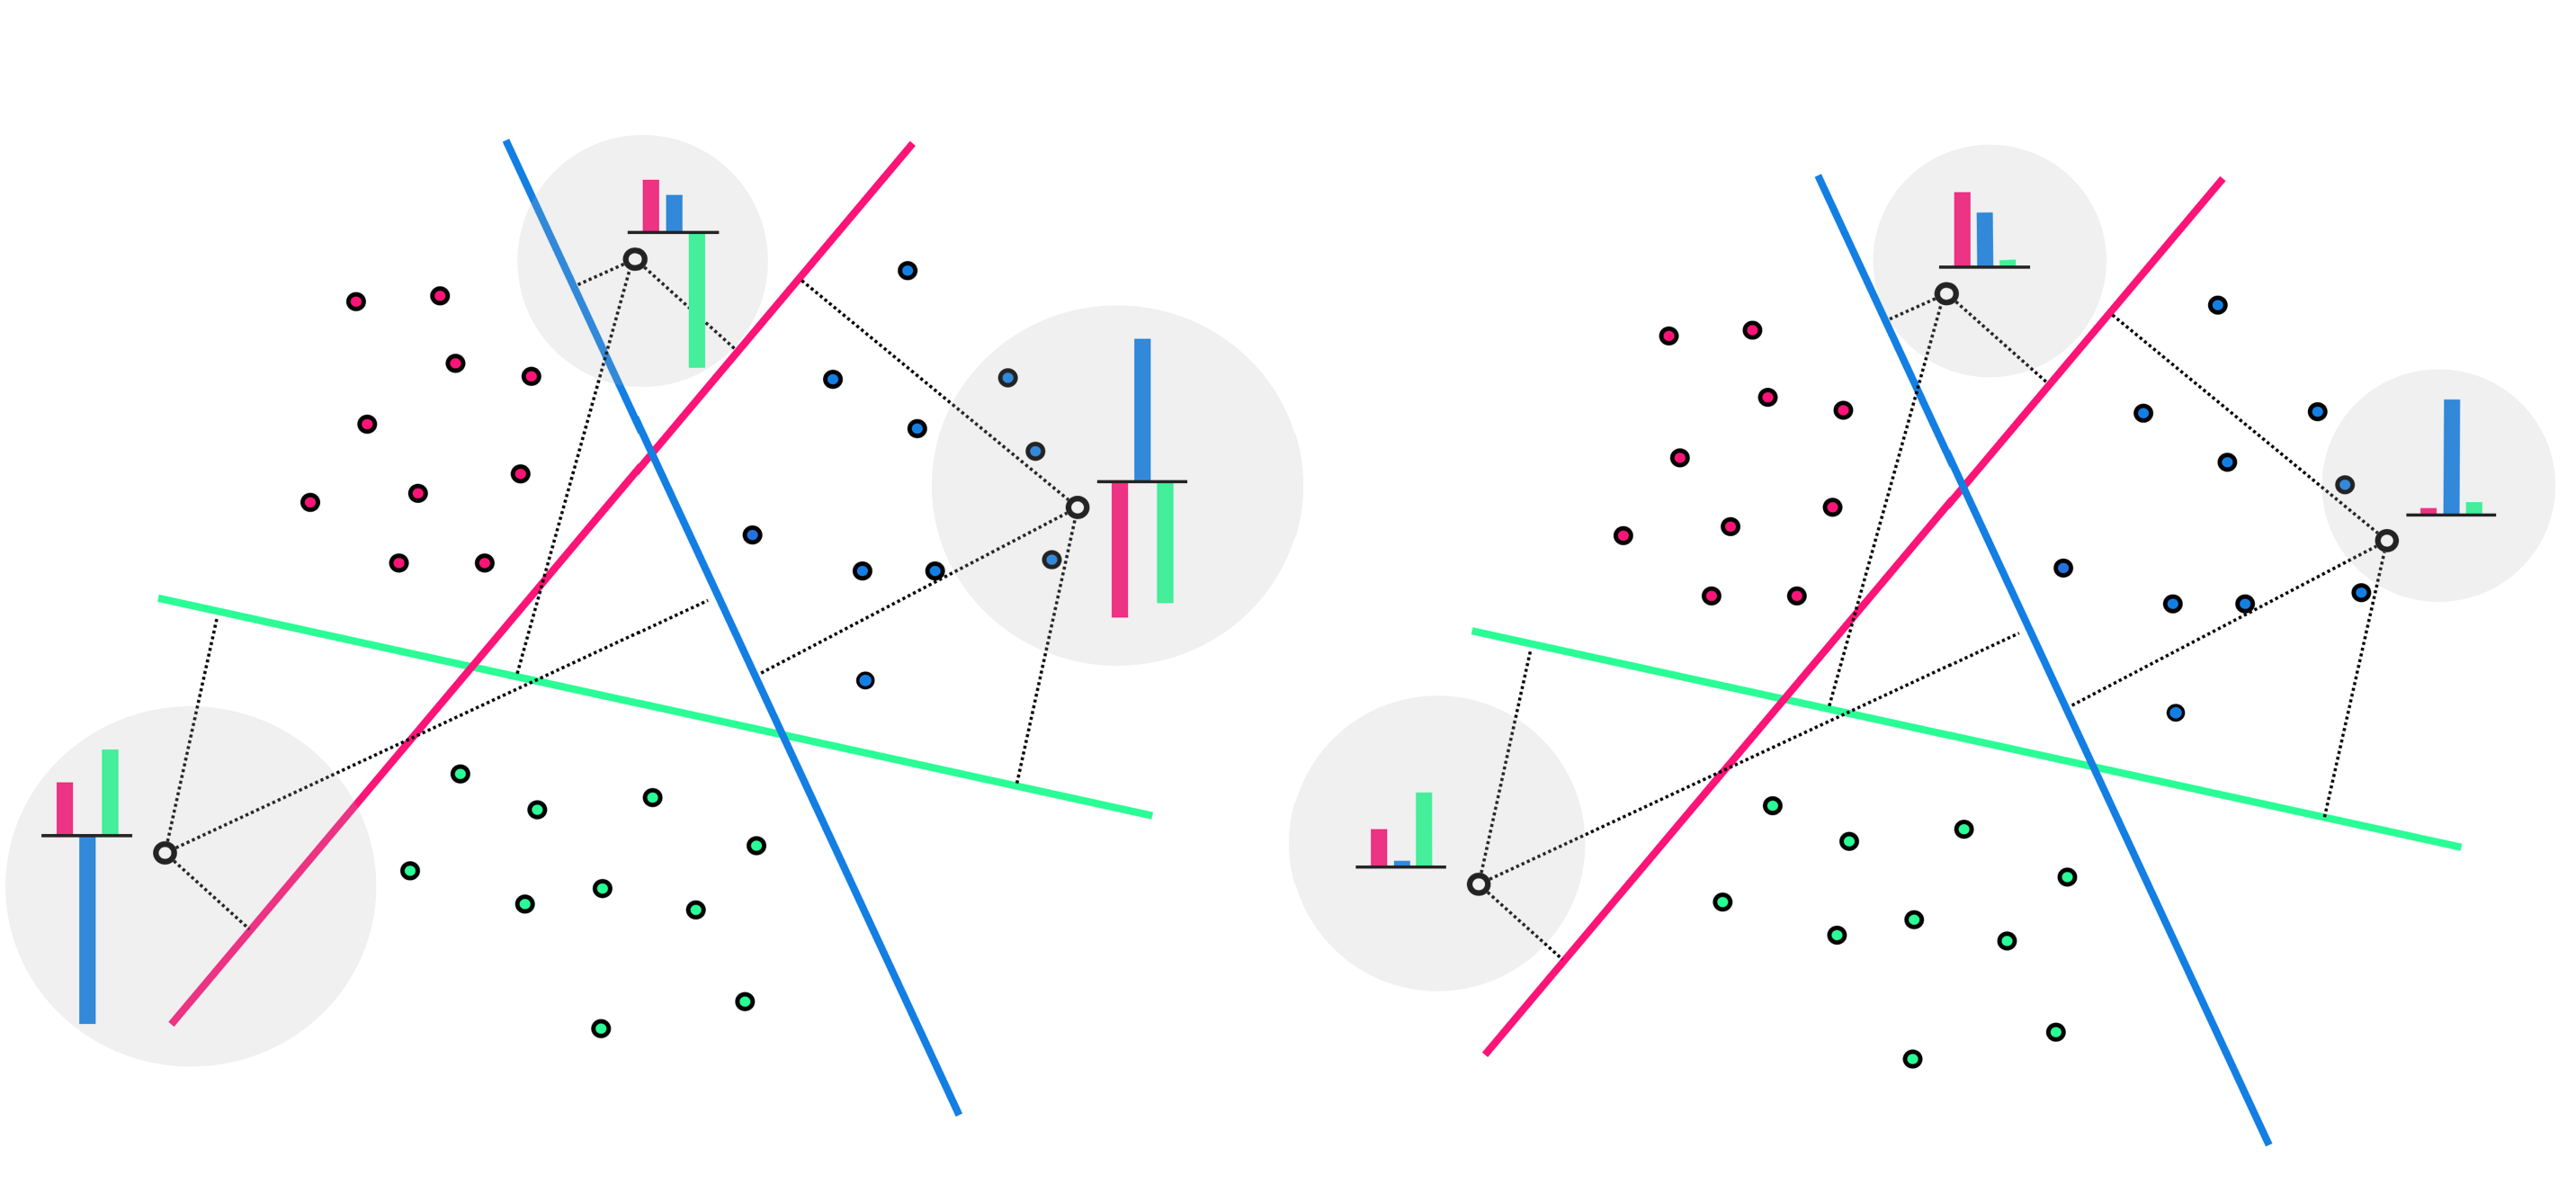

In [ ]:
Image(image_path_3)

<figure>
  <figcaption>   
<strong>Figure 3:</strong> <em> 
(left panel) Histogram visualizations of signed distance measurements of three exemplar points in a $C = 3$ class dataset.  (right panel) Exponentially normalized signed distance measurements visualized as histograms for the same three points.
</em>  </figcaption> 
</figure>

Transforming the histogram of signed distance measurements also gives us a way of considering class ownership *probabilistically*.  For example, if for a particular setting of the entire set of weights $\mathbf{W}$ we had for a particular point $\mathbf{x}_p$

\begin{equation}
\begin{matrix}
\sigma \left(\mathring{\mathbf{x}}_{p}^T\mathbf{W} \right) \end{matrix} = 
\begin{bmatrix} 0.1,\, 0.7,\, 0.2 \end{bmatrix}
\end{equation}

then while we would still *assign a label based on the fusion rule* - here assigning the label $y_p = 1$ since the second entry $0.7$ of this vector is largest - we could also add a note of confidence that "$y_p = 1$ with $70\%$ probability".

##  One-hot encoded labeling

Suppose we begin with a multi-class class classification dataset $\left\{ \left(\mathbf{x}_{p},y_{p}\right)\right\} _{p=1}^{P}$ with $N$ dimenisional input and transform our numerical label values $y_p \in \left\{0,1,...,C-1\right\}$ with *one-hot encoded vectors* of the form 

\begin{equation}
y_p  = 0 \longleftarrow  \mathbf{y}_p = \begin{bmatrix} 1,\, 0,\, \cdots 0 ,\,0  \end{bmatrix}  \\
y_p  = 1 \longleftarrow  \mathbf{y}_p = \begin{bmatrix} 0,\, 1,\, \cdots 0 ,\,0  \end{bmatrix} \\
y_p  = C-1 \longleftarrow  \mathbf{y}_p = \begin{bmatrix} 0,\, 0,\, \cdots 0 ,\,1  \end{bmatrix}.  \,\,\,\,\,\,\,\,
\end{equation}

Here each one-hot encoded *categorical label* has length $C$ and contains all zeros except a $1$ in the index equal to the value of $y_p$.  

Each vector representation uniquely identifies its corresponding label value, but now our label values are no longer *ordered numerical values*, and our dataset now takes the form $\left\{ \left(\mathbf{x}_{p},\mathbf{y}_{p}\right)\right\} _{p=1}^{P}$ where $\mathbf{y}_p$ is defined as above.  Our goal, however, remains the same: to properly tune the $\left(N+1\right) \times C$ weight matrix $\mathbf{W}$ to learn the best correspondence between the $N$ dimensional input and $C$ dimensional output in our dataset.  

##  Multi-class classification meet Multi-output regression

However notice now that we have *vector output* instead of scalar numerical values that our problem is now an instance of *multi-output regression*, as detailed for the linear case in [Section 5.6](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_6_Multi.html).  In other words, if we aimed to learn a *linear* relationship between our input and output we would want to tune $\mathbf{W}$ so that

\begin{equation}
\mathring{\mathbf{x}}_{p}^T\mathbf{W} \approx \mathbf{y}_p
\end{equation}

holds as closely as possible for as many datapoints as possible.  But of course we *know* our output $\mathbf{y}_p$ does not consist of continuous values but are one-hot encoded vectors, and so a linear model would not represent such vectors very well at all.  However we know that *normalized exponential* transforms such a linear combination so that a) the numerical order of its entries is preserved b) all of its entires become nonnegative and c) the sum of its entries equals exactly $1$.  So we could indeed tune $\mathbf{W}$ so that

\begin{equation}
\sigma\left(\mathring{\mathbf{x}}_{p}^T\mathbf{W}\right) \approx \mathbf{y}_p
\end{equation}

where $\sigma\left(\cdot\right)$ is the normalized exponential transformation described above.  Interpreting $\sigma\left(\mathring{\mathbf{x}}_{p}^T\mathbf{W}\right)$ as a discrete probability distribution, this is saying that we want to tune the weights of our model so that this distribution concentrates completely at index $y_p$ i.e., the only non-zero entry of the one-hot encoded output $\mathbf{y}_p$.

##  Choosing a cost function

To learn our weights properly we could employ a standard pointwise regression cost like e.g., the Least Squares (see [Section 5.6](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_6_Multi.html))

\begin{equation}
g_p\left(\mathbf{W}\right) = \left\Vert
\sigma\left(\mathring{\mathbf{x}}_{p}^T\mathbf{W}\right) - \mathbf{y}_p \right\Vert_2^2.
\end{equation}

However, as we discussed exensively in Section [6.2](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_2_Cross_entropy.html), [6.3](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_3_Softmax.html), and [6.5](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_5_SVMs.html) a more appropriate pointwise cost when dealing with *binary output* is the Log Error since it more heavily penalizes error in such instances.  Here the Log Error of $\sigma\left(\mathring{\mathbf{x}}_{p}^T\mathbf{W}\right)$ and $\mathbf{y}_p$ can be written as

\begin{equation}
g_p\left(\mathbf{W}\right) = - \sum_{c=0}^C y_{p,c}\,\text{log} \, \sigma
\left(\mathring{\mathbf{x}}_{p}^T\mathbf{W}\right)_c.
\end{equation}

Note that this formula simplifies considerably because $\mathbf{y}_p$ is a one-hot encoded vector, and so all but one summand on the right hand side above equals zero.  This is precisely the index $j = y_p$, where of course the one-hot encoded vector equals one, meaning that therefore the above simplifies too

\begin{equation}
g_p\left(\mathbf{W}\right) = - \text{log} \, \sigma
\left(\mathring{\mathbf{x}}_{p}^T\mathbf{W}\right)_{y_p}
\end{equation}

and from the definition of the normalized exponential this is precisely

\begin{equation}
g_p\left(\mathbf{W}\right) = - \text{log}\left(  \frac{  e^{\mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{w}}_{y_p}^{\,} } }  {\sum_{c = 0}^{C-1} e^{\mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{w}}_{c}^{\,} } } \right).
\end{equation}

If we then form a cost function by taking the average of the above over all $P$ datapoints we have the so-called *Categorical Cross Entropy* cost function

\begin{equation}
g\left(\mathbf{W}\right) = - \frac{1}{P}\sum_{p=1}^P\text{log}\left(  \frac{  e^{\mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{w}}_{y_p}^{\,} } }  {\sum_{c = 0}^{C-1} e^{\mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{w}}_{c}^{\,} } } \right).
\end{equation}

However this is precisely a form of the standard Multi-class Softmax cost function we saw in 7.2.6 where we used numerical label values $y_p \in \left\{0,1,...,C-1\right\}$.

Note that we could have come to the same conclusion if we simply began with categorical one-hot encoded labels, instead of translating numerical labels into them.  Thus our choice of label values (whether numerical or categorical) is truly arbitrray.